In [1]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from glob import glob
import shutil
from tqdm import tqdm

import numpy as np
import nibabel as nib
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm
from monai.transforms import(
    Compose,
    #AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

"""
This file is for preporcessing only, it contains all the functions that you need
to make your data ready for training.

You need to install the required libraries if you do not already have them.

pip install os, ...
"""
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, EfficientNetBN
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch
#from preporcess import prepare
#from utilities import train

2024-02-05 03:36:32.126700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 03:36:32.126811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 03:36:32.300841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import numpy as np
from monai.transforms import LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityRanged, CropForegroundd, Resized, ToTensord, Compose, MapTransform

class SequentialPatchExtractiond(MapTransform):
    def __init__(self, keys, patch_size, stride):
        super().__init__(keys)
        self.patch_size = patch_size
        self.stride = stride

    def __call__(self, data):
        # Assuming data contains keys "vol" and "seg"
        input_image = data["vol"]
        input_mask = data["seg"]

        sequential_patches = []
        sequential_patches_mask = []
        #print(input_image.shape)
        # Iterate through the image using the patch size and stride
        c=0
        for i in range(0, input_image.shape[1] , self.stride[0]):
            for j in range(0, input_image.shape[2]  , self.stride[1]):
                for k in range(0, input_image.shape[3] , self.stride[2]):
                    # Create SpatialCrop transform for each patch
                    #print(c)
                    #print(i,j,k)
                    c=c+1
                    spatial_crop = SpatialCrop((i, j, k), self.patch_size)

                    # Apply the transform to the input image
                    patch = spatial_crop(input_image)
                    patch_mask = spatial_crop(input_mask)
                    
                    #print(patch.shape)
                    #print(patch_mask.shape)
                    #print()
                    
                    # Add the patch to the list
                    sequential_patches.append(patch)
                    sequential_patches_mask.append(patch_mask)
        # Convert the list of patches to a NumPy array
        sequential_patches = torch.stack(sequential_patches)
        sequential_patches_mask = torch.stack(sequential_patches_mask)
        
        #print(sequential_patches.shape)

        # Update the data dictionary with the sequential patches
        data["vol"] = sequential_patches
        data["seg"] =sequential_patches_mask
        return data



In [4]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[384,384,128], cache=False):

    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you 
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)
    
    #print(os.path.join(in_dir, "train_image", "*.nii"))
    path_train_volumes = sorted(glob.glob(os.path.join(in_dir, "train_image", "*.nii")))
    path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "train_mask", "*.nii")))

    path_test_volumes = sorted(glob.glob(os.path.join(in_dir, "test_image", "*.nii")))
    path_test_segmentation = sorted(glob.glob(os.path.join(in_dir, "test_mask", "*.nii")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),  # Ensure channel first
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            
            #random crop
            RandCropByPosNegLabeld(
                keys=["vol", "seg"],
                label_key="seg",
                spatial_size=(128,128,64),
                num_samples=16,
                image_key="vol",
                image_threshold=0,
            ),
            
            ToTensord(keys=["vol", "seg"]),
        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),  # Ensure channel first
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            
            RandCropByPosNegLabeld(
                keys=["vol", "seg"],
                label_key="seg",
                spatial_size=(128,128,64),
                num_samples=4,
                image_key="vol",
                image_threshold=0,
            ),
            ToTensord(keys=["vol", "seg"]),
        ]
    )


    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=4)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [5]:
def show_patient(data, SLICE_NUMBER=1, train=False, test=True):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.
    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)
    
    print(view_test_patient[0]["vol"].shape)
    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient[0]["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient[0]["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient[0]["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient[0]["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

In [6]:
data_dir = '/kaggle/input/cerebrovascular-segmentation/thesisnewdataset'
model_dir = '/kaggle/working/' 
#data_in = prepare(data_dir, cache=True)
data_in = prepare(data_dir)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [7]:
def infer(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[384,384,128], cache=False):

    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you 
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)
    
    #print(os.path.join(in_dir, "train_image", "*.nii"))
    path_train_volumes = sorted(glob.glob(os.path.join(in_dir, "train_image", "*.nii")))
    path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "train_mask", "*.nii")))

    path_test_volumes = sorted(glob.glob(os.path.join(in_dir, "test_image", "*.nii")))
    path_test_segmentation = sorted(glob.glob(os.path.join(in_dir, "test_mask", "*.nii")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),  # Ensure channel first
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            
            #random crop
            RandCropByPosNegLabeld(
                keys=["vol", "seg"],
                label_key="seg",
                spatial_size=(128,128,64),
                num_samples=16,
                image_key="vol",
                image_threshold=0,
            ),
            
            ToTensord(keys=["vol", "seg"]),
        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),  # Ensure channel first
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            
#             RandCropByPosNegLabeld(
#                 keys=["vol", "seg"],
#                 label_key="seg",
#                 spatial_size=(128,128,64),
#                 num_samples=4,
#                 image_key="vol",
#                 image_threshold=0,
#             ),
            SequentialPatchExtractiond(keys=["vol"], patch_size=(128,128,64), stride=(128,128,64)),

            ToTensord(keys=["vol", "seg"]),
        ]
    )


    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=4)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [8]:
data_dir = '/kaggle/input/cerebrovascular-segmentation/thesisnewdataset'
model_dir = '/kaggle/working/' 
#data_in = prepare(data_dir, cache=True)
data_reconstruct = infer(data_dir)

torch.Size([1, 1, 128, 128, 64])


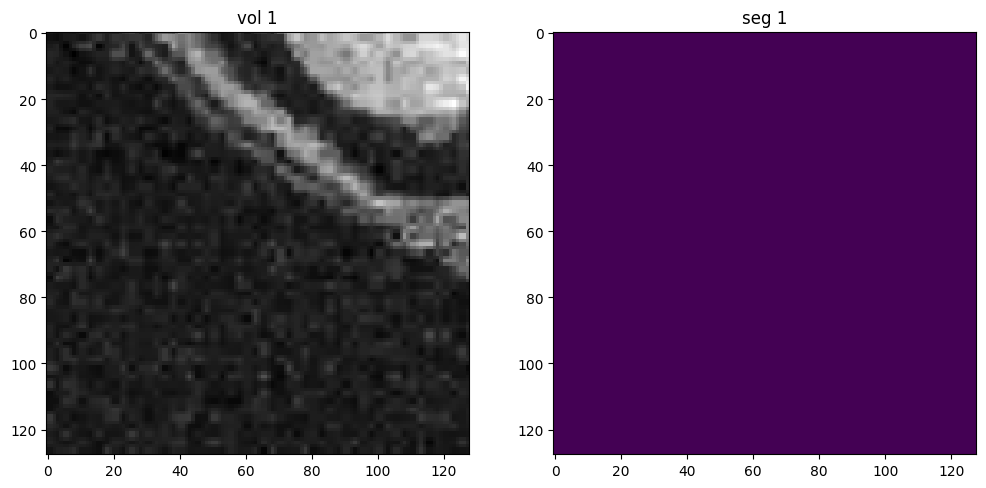

In [9]:
show_patient(data_in)

In [10]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch
#from preporcess import prepare
#from utilities import train
device = torch.device("cuda:0")
# model = UNet(
#     3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256, 512), 
#     strides=(2, 2, 2,2,2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# )
# model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

In [11]:
from monai.networks.nets import DynUNet
from monai.networks.layers import Norm
spacing = (1.5, 1.5, 1.0)
patch_size = (128, 128, 64)
"""
Network preparation
"""
print("*** Preparing the network ...")
# automatically extracts the strides and kernels based on nnU-Net empirical rules
spacings = spacing[:3]
sizes = patch_size[:3]
strides, kernels = [], []
while True:
    spacing_ratio = [sp / min(spacings) for sp in spacings]
    stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
    kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
    if all(s == 1 for s in stride):
        break
    sizes = [i / j for i, j in zip(sizes, stride)]
    spacings = [i * j for i, j in zip(spacings, stride)]
    kernels.append(kernel)
    strides.append(stride)
strides.insert(0, len(spacings) * [1])
kernels.append(len(spacings) * [3])

model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    kernel_size=kernels,
    strides=strides,
    upsample_kernel_size=strides[1:],
    norm_name="instance",
    deep_supervision=False,  # Set this to False
    deep_supr_num=2,
    res_block=False,
)
model_path = '/kaggle/input/thesis-best-model-parameters/focalloss40epoch.pth'
state_dict = torch.load(model_path)
if "module." in list(state_dict.keys())[0]:
    # Remove "module." prefix
    state_dict = {k[7:]: v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model.to(device)
#model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

*** Preparing the network ...


DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(64, eps=1e-05

In [12]:
print(model)

DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(64, eps=1e-05

In [13]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

In [14]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

In [15]:
def plot_result(test_outputs,test_label):
    patch_outputs = torch.argmax(test_outputs, dim=1, keepdim=True) # torch.Size([64, 2, 128, 128, 32]) to torch.Size([64, 1, 128, 128, 32])
    print(patch_outputs.shape)


    ## Set a seed for reproducibility
    random.seed(42)

    # Generate a list of 10 random indices
    random_indices = random.sample(range(32), 5)

    print(random_indices)


    # Plot random slices
    for idx in random_indices:
        # Plot slice from patch_outputs
        plt.figure(figsize=(10, 5))

            # Plot corresponding slice from test_label
        plt.subplot(1, 3, 1)
        plt.imshow(test_label[0, 0, :, :, idx].cpu().numpy(), cmap='gray')
        plt.title(f'Test Label - Index {idx}')

        plt.subplot(1, 3, 2)
        plt.imshow(patch_outputs[0, 0, :, :, idx].cpu().numpy(), cmap='gray')
        plt.title(f'Patch Output - Index {idx}')
        #print(patch_outputs[idx, 0, :, :, patch_outputs.shape[4] // 2].cpu().numpy())




        pred = patch_outputs.cpu().numpy() /255.0
        prob_masks = (pred> 0.0035).astype(int)
        #print(prob_masks)

        plt.subplot(1, 3, 3)
        plt.imshow(prob_masks[0, 0, :, :, idx], cmap='gray')
        plt.title(f'prob_masks - Index {idx}')


        plt.show()

    
                

In [16]:
#all ok works fine
import gc
def train(model, data_in, loss, dice_ce_loss_function, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1
            train_batch_loss = 0
            batch_metric_train = 0
            for i in range(len(batch_data)):
                volume = batch_data[i]["vol"]
                label = batch_data[i]["seg"]
                label = label != 0
                
#                 print("vol label")
#                 print(volume.shape) 
#                 print(label.shape)
            
                volume, label = (volume.to(device), label.to(device))
                #print(volume.shape)
                optim.zero_grad()
                outputs = model(volume)
                
            
#                 print("output")
#                 print(outputs.shape)
            
                train_loss = loss(outputs, label) # * 0.3 + 0.7 * dice_ce_loss_function(outputs, label)

            
                train_loss.backward()
                optim.step()

                
                train_batch_loss += train_loss.item()
#                 print(
#                 f"{i} / {train_step}/{len(train_loader) // 1}, "
#                 f"Train_loss: {train_loss.item():.4f}")

                train_metric = dice_metric(outputs, label)
                batch_metric_train += train_metric
                #print(f'Train_patch_dice: {train_metric:.4f}')
                
                
                
                del volume
                del label
                gc.collect()
                torch.cuda.empty_cache()
            
            train_epoch_loss += train_batch_loss / len(batch_data)
            
            print(
                f"{train_step}/{len(train_loader) // 1}, "
                f"Train_loss: {train_batch_loss / len(batch_data):.4f}")

            
            epoch_metric_train += batch_metric_train / len(batch_data)
            print(f'Train_batch_dice: {batch_metric_train / len(batch_data):.4f}')
                
                
                
                
                

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Total_Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Total_Epoch_dice_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        
        
        
        #testing
        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:
                    #print(test_data["vol"].shape)
                    test_step += 1
                    
                    test_batch_loss = 0
                    batch_metric_test = 0
                    
                    for i in range(len(test_data)):
                        
                        test_volume = test_data[i]["vol"]
                        test_label = test_data[i]["seg"]
                        test_label = test_label != 0
#                         print(test_volume.shape)
#                         print(test_label.shape)

                        test_volume, test_label = (test_volume.to(device), test_label.to(device))
                        #print(test_volume.shape)
                        #test_outputs = model(test_volume)
                        #print("ok1")
                        test_outputs = model(test_volume)
#                         print("ok2")
#                         print(test_outputs.shape)
                        
                       
                        #test_loss = loss(test_outputs, test_label)
                        test_loss = loss(test_outputs, test_label)
                        test_batch_loss += test_loss.item()
                        
                        
                        test_metric = dice_metric(test_outputs, test_label)
                        batch_metric_test += test_metric
                    
                    l=len(test_data)
                    test_epoch_loss += (test_batch_loss / l)
                    
                    print(
                    f"{test_step}/ {l} , "
                    f"Test_loss: {test_batch_loss / l:.4f}")
                    
                    
                    epoch_metric_test += (batch_metric_test / l)
                    print(f'Test_batch_dice: {batch_metric_test / l:.4f}')
             
                if (epoch) % 5 == 0:
                        plot_result(test_outputs,test_label)
                   
                print('-'*20)     
                
                test_epoch_loss /= test_step    
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

In [17]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)


In [18]:
from monai.losses import DiceCELoss

# Define the DiceCELoss with appropriate parameters
dice_ce_loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True)


In [19]:
from monai.losses import DiceFocalLoss

# Define the DiceCELoss with appropriate parameters
dice_focal_loss_function = DiceFocalLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)


----------
epoch 1/60
1/9, Train_loss: 0.3249
Train_batch_dice: 0.7015
2/9, Train_loss: 0.3495
Train_batch_dice: 0.6760
3/9, Train_loss: 0.3213
Train_batch_dice: 0.7045
4/9, Train_loss: 0.3363
Train_batch_dice: 0.6896
5/9, Train_loss: 0.3231
Train_batch_dice: 0.7036
6/9, Train_loss: 0.3234
Train_batch_dice: 0.7030
7/9, Train_loss: 0.3009
Train_batch_dice: 0.7260
8/9, Train_loss: 0.3146
Train_batch_dice: 0.7108
9/9, Train_loss: 0.3326
Train_batch_dice: 0.6912
--------------------
Total_Epoch_loss: 0.3252
Total_Epoch_dice_metric: 0.7007
1/ 4 , Test_loss: 0.3525
Test_batch_dice: 0.6729
2/ 4 , Test_loss: 0.2893
Test_batch_dice: 0.7377
3/ 4 , Test_loss: 0.3147
Test_batch_dice: 0.7111
4/ 4 , Test_loss: 0.3324
Test_batch_dice: 0.6919
5/ 4 , Test_loss: 0.4214
Test_batch_dice: 0.6000
6/ 4 , Test_loss: 0.3017
Test_batch_dice: 0.7244
7/ 4 , Test_loss: 0.2779
Test_batch_dice: 0.7501
8/ 4 , Test_loss: 0.3539
Test_batch_dice: 0.6707
torch.Size([1, 1, 128, 128, 64])
[7, 1, 17, 15, 14]


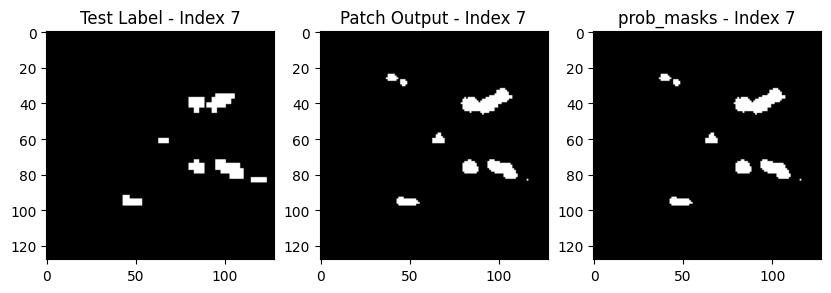

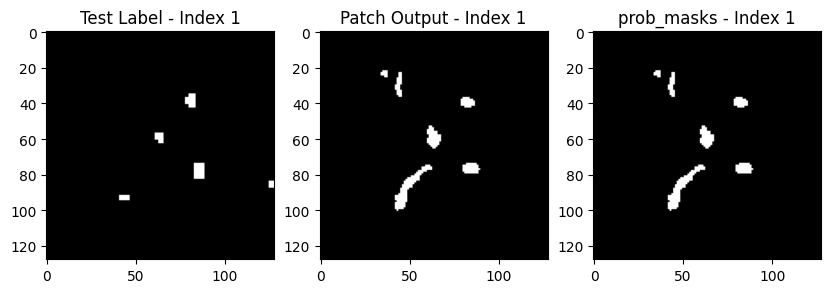

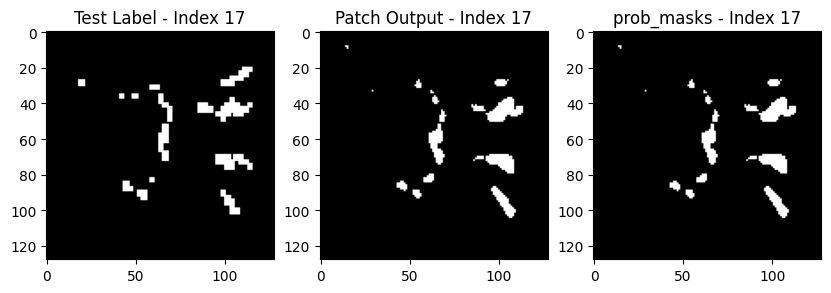

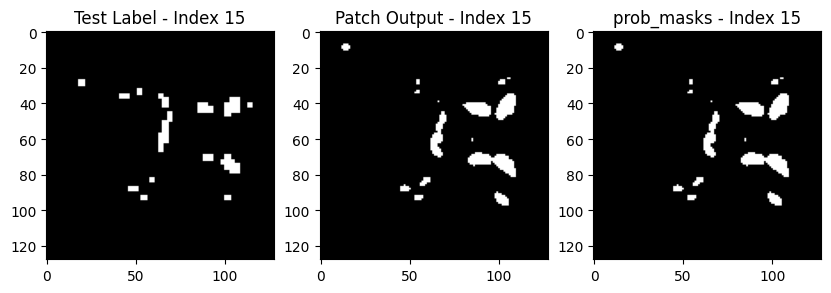

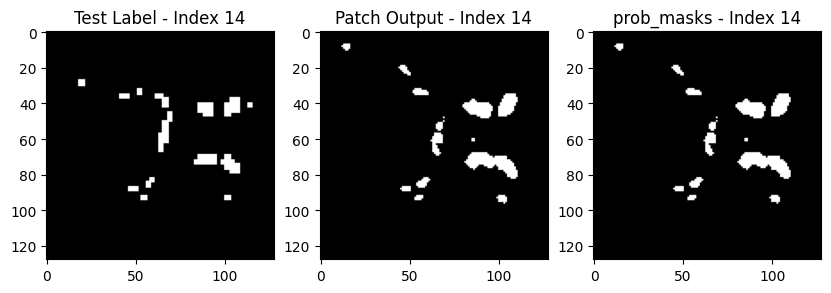

--------------------
test_loss_epoch: 0.3305
test_dice_epoch: 0.6949
current epoch: 1 current mean dice: 0.7779
best mean dice: 0.6949 at epoch: 1
----------
epoch 2/60
1/9, Train_loss: 0.3485
Train_batch_dice: 0.6753
2/9, Train_loss: 0.3279
Train_batch_dice: 0.6989
3/9, Train_loss: 0.3147
Train_batch_dice: 0.7115
4/9, Train_loss: 0.3163
Train_batch_dice: 0.7106
5/9, Train_loss: 0.2957
Train_batch_dice: 0.7314
6/9, Train_loss: 0.3131
Train_batch_dice: 0.7132
7/9, Train_loss: 0.3194
Train_batch_dice: 0.7052
8/9, Train_loss: 0.3284
Train_batch_dice: 0.6963
9/9, Train_loss: 0.3254
Train_batch_dice: 0.6985
--------------------
Total_Epoch_loss: 0.3211
Total_Epoch_dice_metric: 0.7045
1/ 4 , Test_loss: 0.2586
Test_batch_dice: 0.7783
2/ 4 , Test_loss: 0.3303
Test_batch_dice: 0.6967
3/ 4 , Test_loss: 0.3406
Test_batch_dice: 0.6851
4/ 4 , Test_loss: 0.3004
Test_batch_dice: 0.7294
5/ 4 , Test_loss: 0.2547
Test_batch_dice: 0.7723
6/ 4 , Test_loss: 0.2726
Test_batch_dice: 0.7611
7/ 4 , Test_loss: 

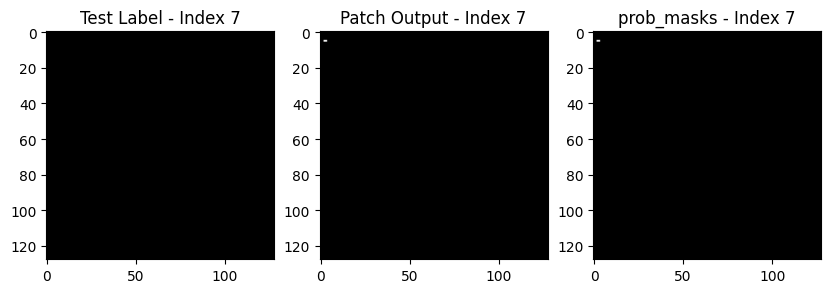

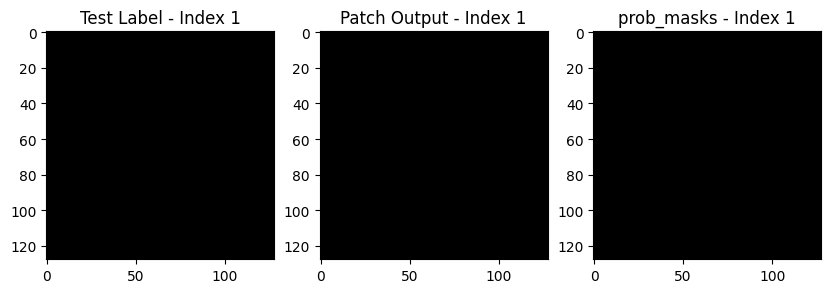

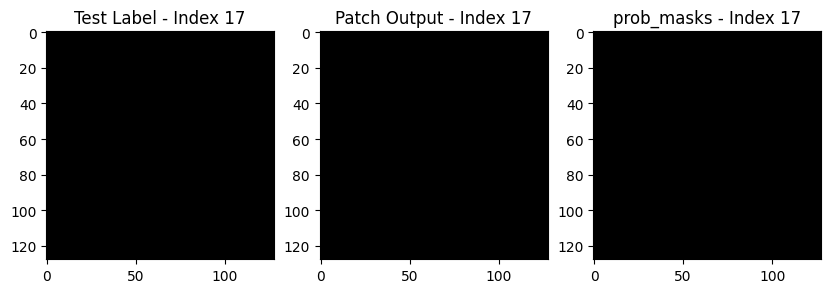

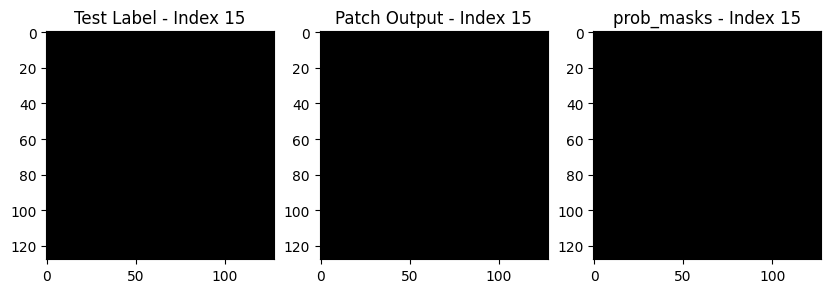

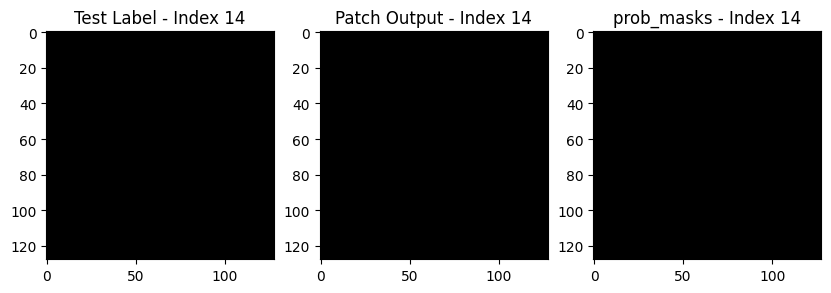

--------------------
test_loss_epoch: 0.3169
test_dice_epoch: 0.7065
current epoch: 6 current mean dice: 0.6597
best mean dice: 0.7287 at epoch: 2
----------
epoch 7/60
1/9, Train_loss: 0.3104
Train_batch_dice: 0.7142
2/9, Train_loss: 0.3163
Train_batch_dice: 0.7083
3/9, Train_loss: 0.3253
Train_batch_dice: 0.6967
4/9, Train_loss: 0.3311
Train_batch_dice: 0.6933
5/9, Train_loss: 0.2886
Train_batch_dice: 0.7368
6/9, Train_loss: 0.3114
Train_batch_dice: 0.7127
7/9, Train_loss: 0.2963
Train_batch_dice: 0.7276
8/9, Train_loss: 0.3387
Train_batch_dice: 0.6822
9/9, Train_loss: 0.3151
Train_batch_dice: 0.7067
--------------------
Total_Epoch_loss: 0.3148
Total_Epoch_dice_metric: 0.7087
1/ 4 , Test_loss: 0.2942
Test_batch_dice: 0.7314
2/ 4 , Test_loss: 0.3127
Test_batch_dice: 0.7095
3/ 4 , Test_loss: 0.3462
Test_batch_dice: 0.6763
4/ 4 , Test_loss: 0.3150
Test_batch_dice: 0.7088
5/ 4 , Test_loss: 0.3157
Test_batch_dice: 0.7091
6/ 4 , Test_loss: 0.3205
Test_batch_dice: 0.7013
7/ 4 , Test_loss: 

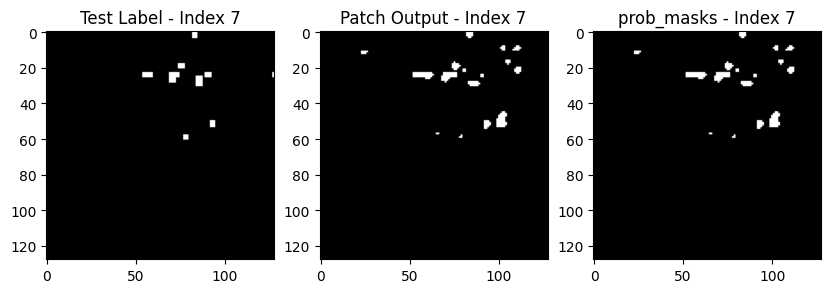

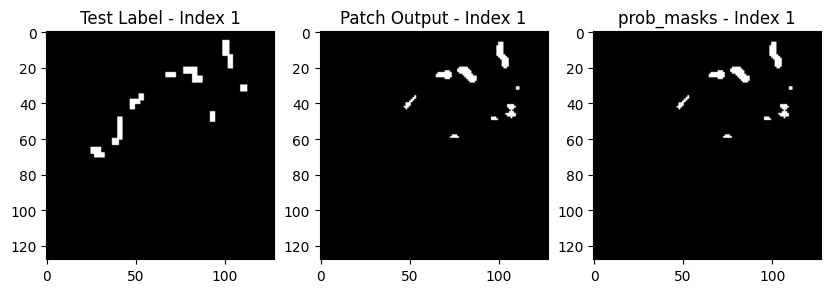

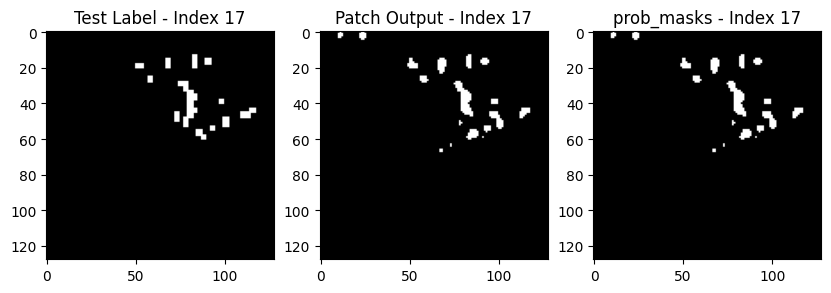

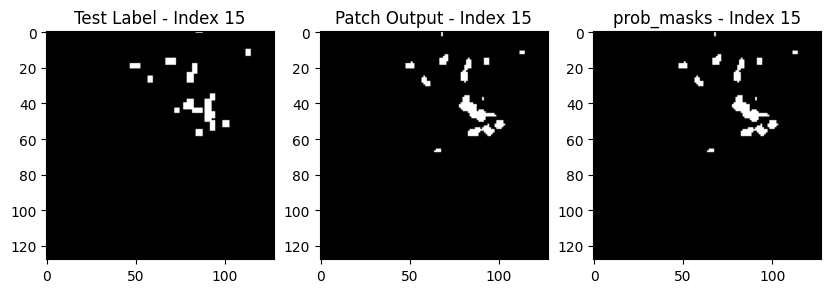

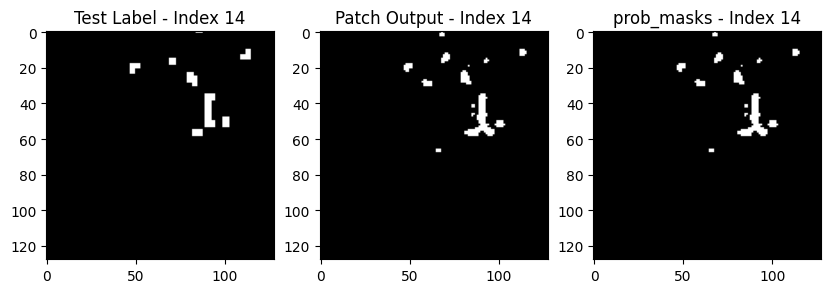

--------------------
test_loss_epoch: 0.2964
test_dice_epoch: 0.7262
current epoch: 11 current mean dice: 0.7592
best mean dice: 0.7323 at epoch: 8
----------
epoch 12/60
1/9, Train_loss: 0.2776
Train_batch_dice: 0.7469
2/9, Train_loss: 0.2735
Train_batch_dice: 0.7511
3/9, Train_loss: 0.2913
Train_batch_dice: 0.7304
4/9, Train_loss: 0.3031
Train_batch_dice: 0.7198
5/9, Train_loss: 0.2863
Train_batch_dice: 0.7362
6/9, Train_loss: 0.2707
Train_batch_dice: 0.7540
7/9, Train_loss: 0.2863
Train_batch_dice: 0.7354
8/9, Train_loss: 0.2868
Train_batch_dice: 0.7336
9/9, Train_loss: 0.3028
Train_batch_dice: 0.7162
--------------------
Total_Epoch_loss: 0.2865
Total_Epoch_dice_metric: 0.7360
1/ 4 , Test_loss: 0.3017
Test_batch_dice: 0.7164
2/ 4 , Test_loss: 0.2574
Test_batch_dice: 0.7652
3/ 4 , Test_loss: 0.2560
Test_batch_dice: 0.7723
4/ 4 , Test_loss: 0.3557
Test_batch_dice: 0.6640
5/ 4 , Test_loss: 0.3266
Test_batch_dice: 0.6978
6/ 4 , Test_loss: 0.3032
Test_batch_dice: 0.7178
7/ 4 , Test_loss

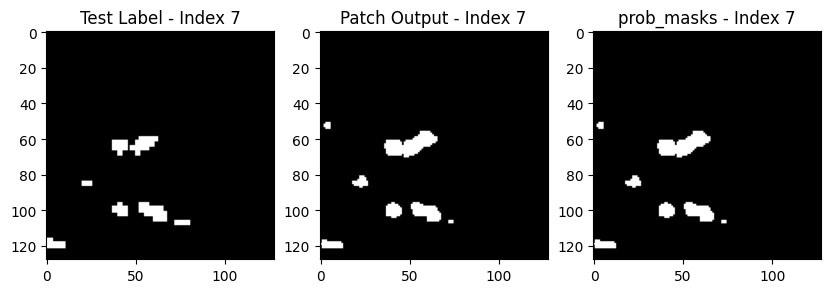

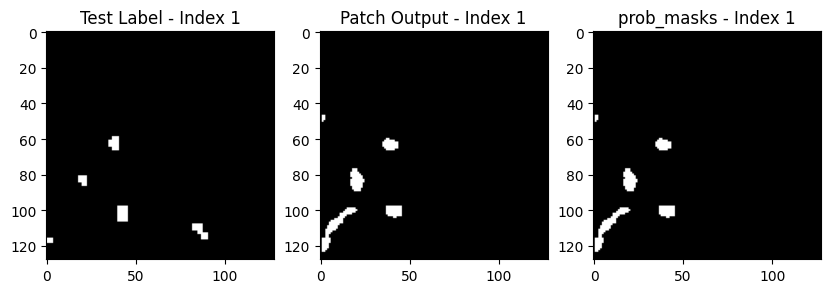

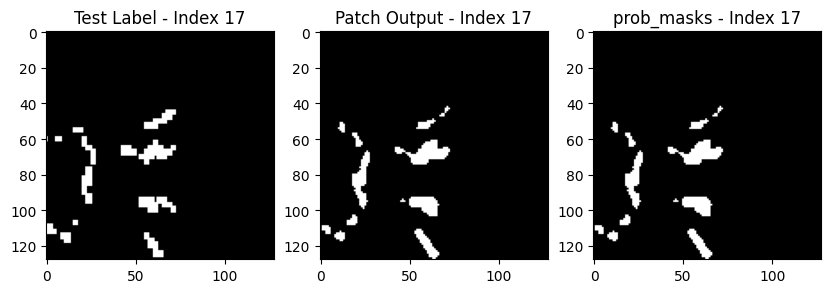

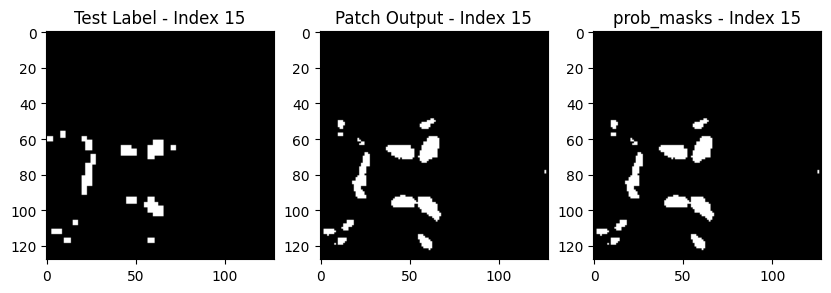

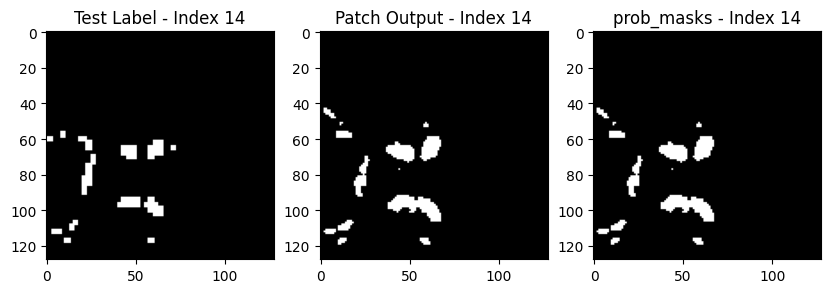

--------------------
test_loss_epoch: 0.2906
test_dice_epoch: 0.7303
current epoch: 16 current mean dice: 0.8201
best mean dice: 0.7528 at epoch: 15
----------
epoch 17/60
1/9, Train_loss: 0.2949
Train_batch_dice: 0.7254


KeyboardInterrupt: 

In [20]:

if __name__ == '__main__':
    train(model, data_in, dice_focal_loss_function, dice_ce_loss_function, optimizer, 60, model_dir)

----------
epoch 1/20
2/9, Train_loss: 0.2721
Train_batch_dice: 0.7279
3/9, Train_loss: 0.2687
Train_batch_dice: 0.7313
5/9, Train_loss: 0.2495
Train_batch_dice: 0.7505
6/9, Train_loss: 0.2671
Train_batch_dice: 0.7329
7/9, Train_loss: 0.2509
Train_batch_dice: 0.7491
8/9, Train_loss: 0.2449
Train_batch_dice: 0.7551
9/9, Train_loss: 0.2499
Train_batch_dice: 0.7501
--------------------
Total_Epoch_loss: 0.2598
Total_Epoch_dice_metric: 0.7402
1/ 4 , Test_loss: 0.3210
Test_batch_dice: 0.6790
2/ 4 , Test_loss: 0.2698
Test_batch_dice: 0.7302
3/ 4 , Test_loss: 0.2194
Test_batch_dice: 0.7806
4/ 4 , Test_loss: 0.2492
Test_batch_dice: 0.7508
5/ 4 , Test_loss: 0.3318
Test_batch_dice: 0.6682
6/ 4 , Test_loss: 0.2487
Test_batch_dice: 0.7513
7/ 4 , Test_loss: 0.3989
Test_batch_dice: 0.6011
8/ 4 , Test_loss: 0.2840
Test_batch_dice: 0.7160
torch.Size([1, 1, 128, 128, 64])
[7, 1, 17, 15, 14]


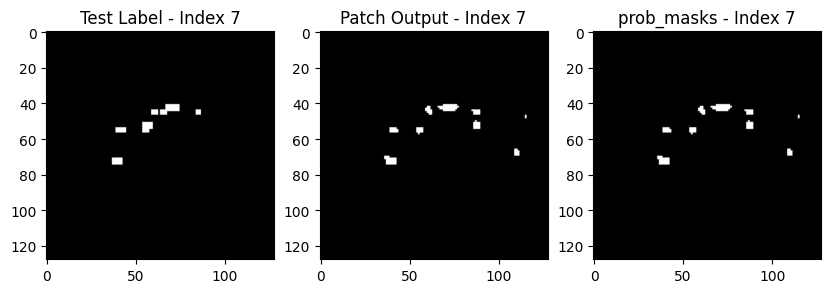

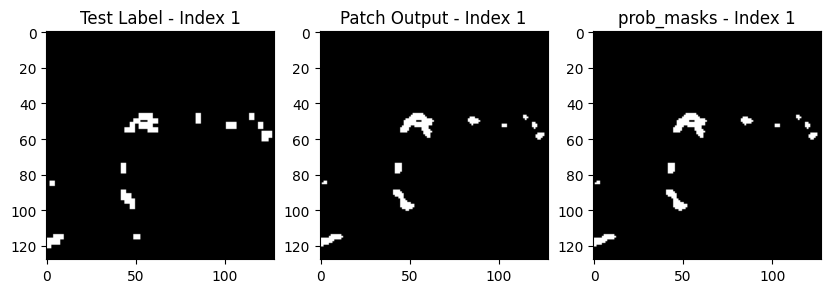

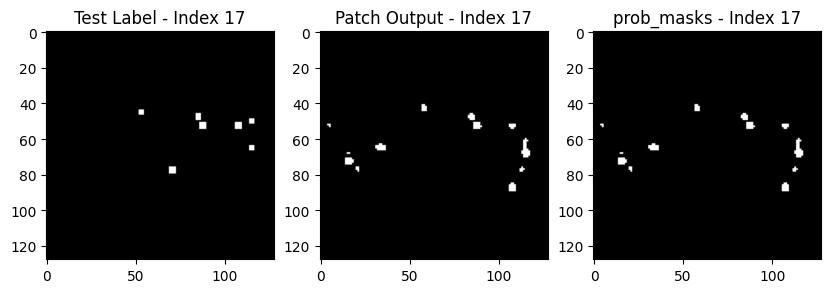

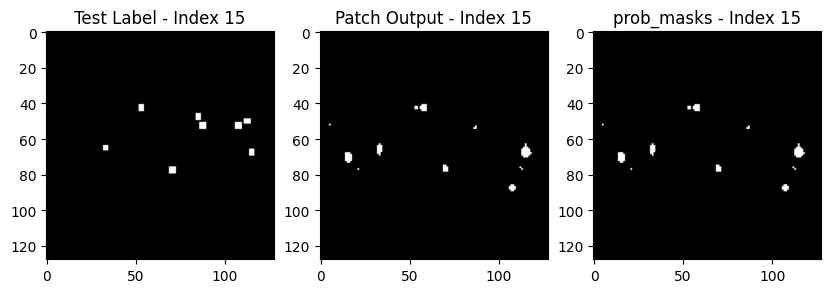

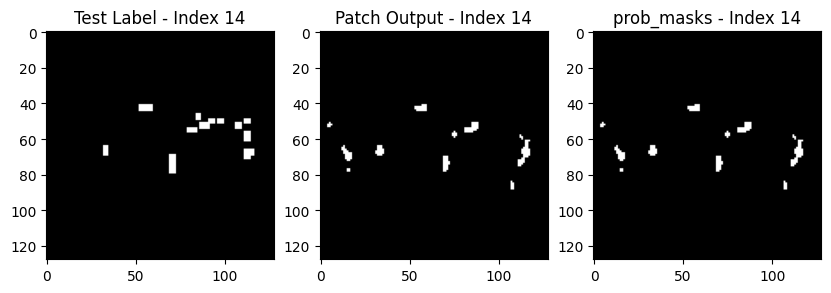

--------------------
test_loss_epoch: 0.2904
test_dice_epoch: 0.7096
current epoch: 1 current mean dice: 0.7356
best mean dice: 0.7096 at epoch: 1
----------
epoch 2/20
1/9, Train_loss: 0.2484
Train_batch_dice: 0.7516
2/9, Train_loss: 0.2656
Train_batch_dice: 0.7344
3/9, Train_loss: 0.2799
Train_batch_dice: 0.7201
4/9, Train_loss: 0.2504
Train_batch_dice: 0.7496
5/9, Train_loss: 0.2620
Train_batch_dice: 0.7380
6/9, Train_loss: 0.2400
Train_batch_dice: 0.7600
7/9, Train_loss: 0.2507
Train_batch_dice: 0.7493
8/9, Train_loss: 0.2557
Train_batch_dice: 0.7443
9/9, Train_loss: 0.2304
Train_batch_dice: 0.7696
--------------------
Total_Epoch_loss: 0.2537
Total_Epoch_dice_metric: 0.7463
1/ 4 , Test_loss: 0.2787
Test_batch_dice: 0.7213
2/ 4 , Test_loss: 0.2476
Test_batch_dice: 0.7524
3/ 4 , Test_loss: 0.2036
Test_batch_dice: 0.7964
4/ 4 , Test_loss: 0.2140
Test_batch_dice: 0.7860
5/ 4 , Test_loss: 0.3476
Test_batch_dice: 0.6524
6/ 4 , Test_loss: 0.2592
Test_batch_dice: 0.7408
7/ 4 , Test_loss: 

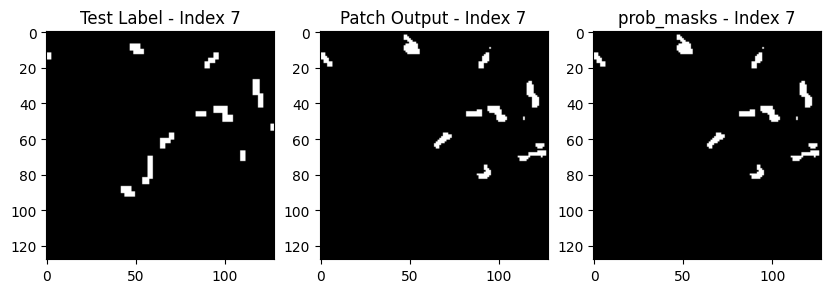

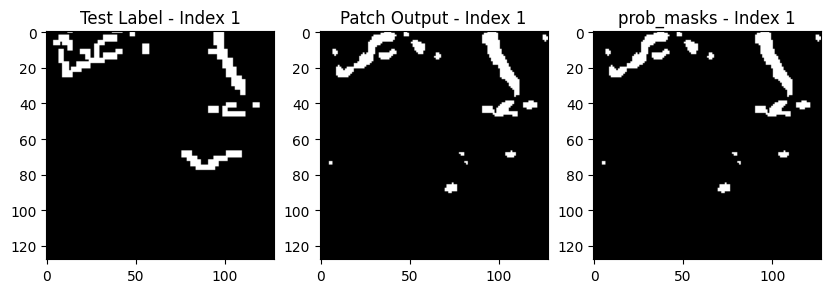

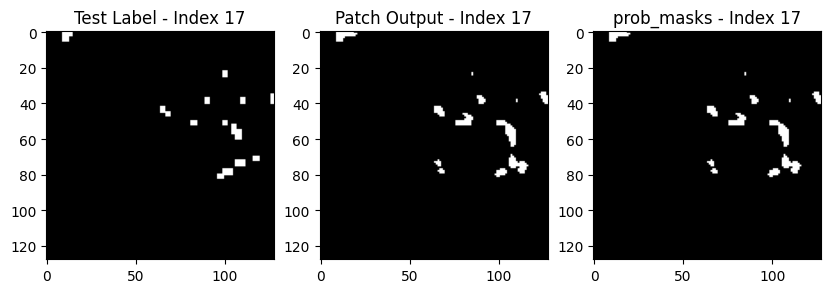

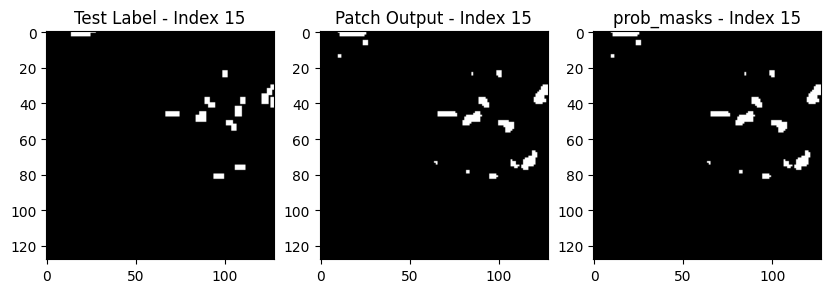

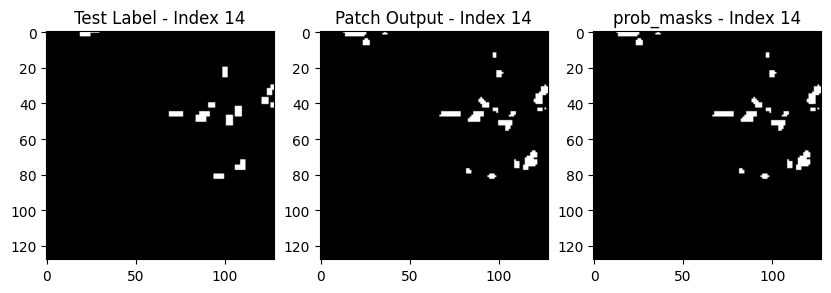

--------------------
test_loss_epoch: 0.2513
test_dice_epoch: 0.7487
current epoch: 6 current mean dice: 0.7926
best mean dice: 0.7487 at epoch: 6
----------
epoch 7/20
1/9, Train_loss: 0.2627
Train_batch_dice: 0.7373
2/9, Train_loss: 0.2631
Train_batch_dice: 0.7369
3/9, Train_loss: 0.2375
Train_batch_dice: 0.7625
4/9, Train_loss: 0.2552
Train_batch_dice: 0.7448
5/9, Train_loss: 0.2307
Train_batch_dice: 0.7693
6/9, Train_loss: 0.2412
Train_batch_dice: 0.7588
7/9, Train_loss: 0.2334
Train_batch_dice: 0.7666
8/9, Train_loss: 0.2355
Train_batch_dice: 0.7645
9/9, Train_loss: 0.2423
Train_batch_dice: 0.7577
--------------------
Total_Epoch_loss: 0.2446
Total_Epoch_dice_metric: 0.7554
1/ 4 , Test_loss: 0.2709
Test_batch_dice: 0.7291
2/ 4 , Test_loss: 0.3014
Test_batch_dice: 0.6986
3/ 4 , Test_loss: 0.2211
Test_batch_dice: 0.7789
4/ 4 , Test_loss: 0.2223
Test_batch_dice: 0.7777
5/ 4 , Test_loss: 0.3570
Test_batch_dice: 0.6430
6/ 4 , Test_loss: 0.2166
Test_batch_dice: 0.7834
7/ 4 , Test_loss: 

KeyboardInterrupt: 

In [24]:

if __name__ == '__main__':
    train(model, data_in, loss_function, dice_ce_loss_function, optimizer, 20, model_dir)

----------
epoch 1/20
1/9, Train_loss: 0.2467
Train_batch_dice: 0.7533
2/9, Train_loss: 0.2439
Train_batch_dice: 0.7561
3/9, Train_loss: 0.2331
Train_batch_dice: 0.7669
4/9, Train_loss: 0.2484
Train_batch_dice: 0.7516
5/9, Train_loss: 0.2439
Train_batch_dice: 0.7561
6/9, Train_loss: 0.2358
Train_batch_dice: 0.7642
7/9, Train_loss: 0.2415
Train_batch_dice: 0.7585
8/9, Train_loss: 0.2283
Train_batch_dice: 0.7717
9/9, Train_loss: 0.2381
Train_batch_dice: 0.7619
--------------------
Total_Epoch_loss: 0.2400
Total_Epoch_dice_metric: 0.7600
1/ 4 , Test_loss: 0.1997
Test_batch_dice: 0.8003
2/ 4 , Test_loss: 0.2846
Test_batch_dice: 0.7154
3/ 4 , Test_loss: 0.2562
Test_batch_dice: 0.7438
4/ 4 , Test_loss: 0.2019
Test_batch_dice: 0.7981
5/ 4 , Test_loss: 0.3011
Test_batch_dice: 0.6989
6/ 4 , Test_loss: 0.2391
Test_batch_dice: 0.7609
7/ 4 , Test_loss: 0.2357
Test_batch_dice: 0.7643
8/ 4 , Test_loss: 0.2487
Test_batch_dice: 0.7513
torch.Size([1, 1, 128, 128, 64])
[7, 1, 17, 15, 14]


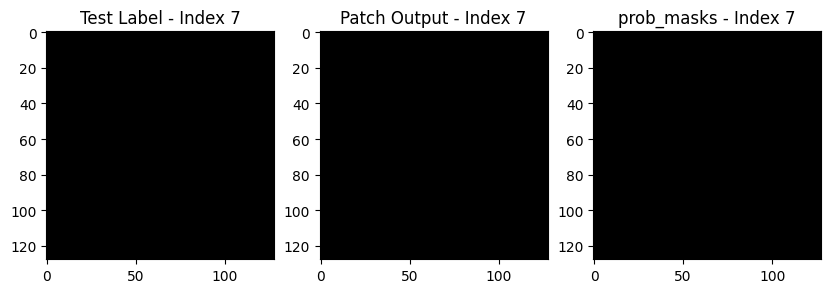

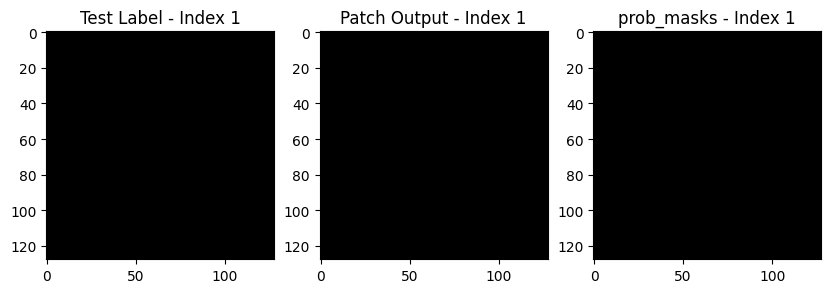

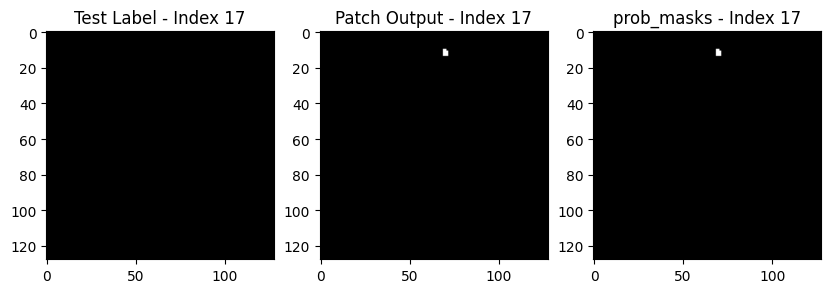

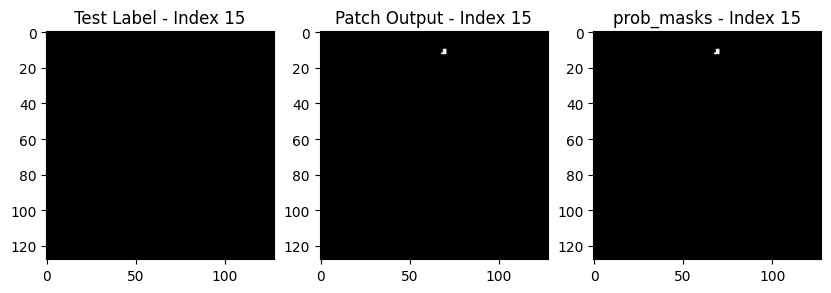

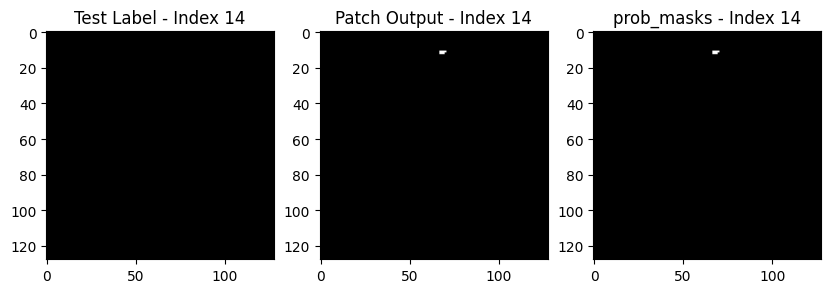

--------------------
test_loss_epoch: 0.2459
test_dice_epoch: 0.7541
current epoch: 1 current mean dice: 0.7653
best mean dice: 0.7541 at epoch: 1
----------
epoch 2/20
1/9, Train_loss: 0.2444
Train_batch_dice: 0.7556
2/9, Train_loss: 0.2416
Train_batch_dice: 0.7584
3/9, Train_loss: 0.2437
Train_batch_dice: 0.7563
4/9, Train_loss: 0.2394
Train_batch_dice: 0.7606
5/9, Train_loss: 0.2269
Train_batch_dice: 0.7731
6/9, Train_loss: 0.2226
Train_batch_dice: 0.7774
7/9, Train_loss: 0.2280
Train_batch_dice: 0.7720
8/9, Train_loss: 0.2347
Train_batch_dice: 0.7653
9/9, Train_loss: 0.2238
Train_batch_dice: 0.7762
--------------------
Total_Epoch_loss: 0.2339
Total_Epoch_dice_metric: 0.7661
1/ 4 , Test_loss: 0.2147
Test_batch_dice: 0.7853
2/ 4 , Test_loss: 0.2706
Test_batch_dice: 0.7294
3/ 4 , Test_loss: 0.2152
Test_batch_dice: 0.7848
4/ 4 , Test_loss: 0.2187
Test_batch_dice: 0.7813
5/ 4 , Test_loss: 0.2058
Test_batch_dice: 0.7942
6/ 4 , Test_loss: 0.2053
Test_batch_dice: 0.7947
7/ 4 , Test_loss: 

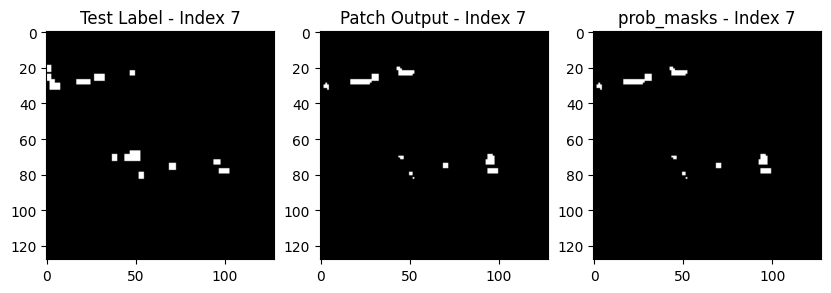

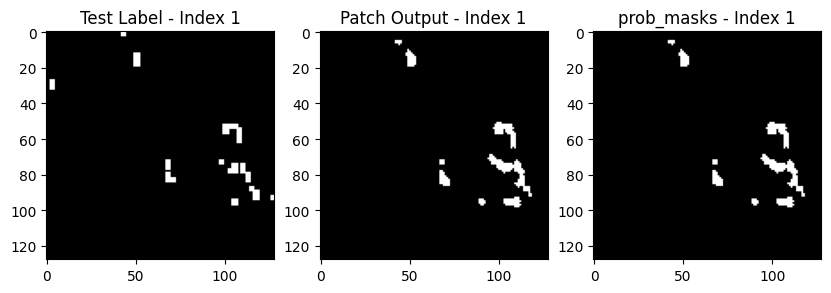

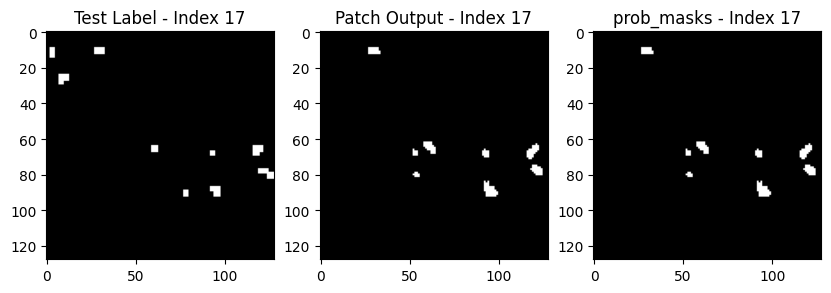

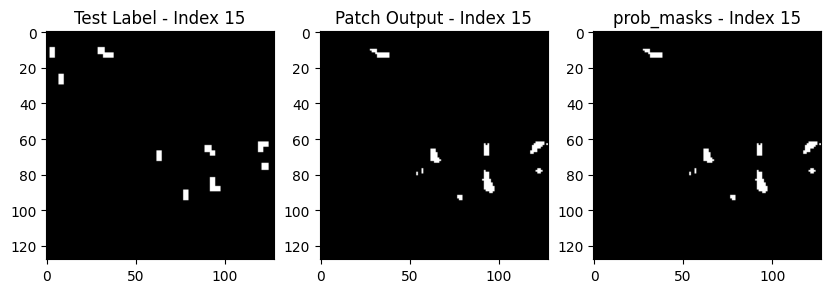

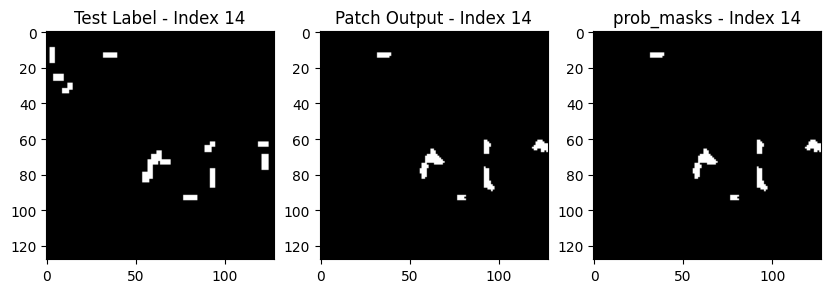

--------------------
test_loss_epoch: 0.2411
test_dice_epoch: 0.7589
current epoch: 6 current mean dice: 0.7307
best mean dice: 0.7855 at epoch: 5
----------
epoch 7/20
1/9, Train_loss: 0.2278
Train_batch_dice: 0.7722
2/9, Train_loss: 0.2279
Train_batch_dice: 0.7721
3/9, Train_loss: 0.2432
Train_batch_dice: 0.7568
4/9, Train_loss: 0.2419
Train_batch_dice: 0.7581
5/9, Train_loss: 0.2505
Train_batch_dice: 0.7495
6/9, Train_loss: 0.2108
Train_batch_dice: 0.7892
7/9, Train_loss: 0.2283
Train_batch_dice: 0.7717
8/9, Train_loss: 0.2239
Train_batch_dice: 0.7761
9/9, Train_loss: 0.2186
Train_batch_dice: 0.7814
--------------------
Total_Epoch_loss: 0.2303
Total_Epoch_dice_metric: 0.7697
1/ 4 , Test_loss: 0.2355
Test_batch_dice: 0.7645
2/ 4 , Test_loss: 0.2136
Test_batch_dice: 0.7864
3/ 4 , Test_loss: 0.1887
Test_batch_dice: 0.8113
4/ 4 , Test_loss: 0.3236
Test_batch_dice: 0.6764
5/ 4 , Test_loss: 0.2099
Test_batch_dice: 0.7901
6/ 4 , Test_loss: 0.1932
Test_batch_dice: 0.8068
7/ 4 , Test_loss: 

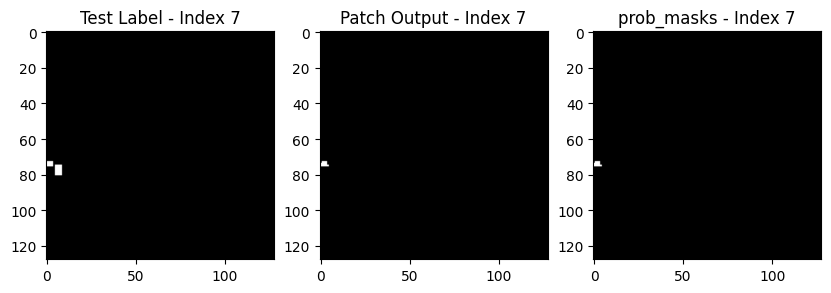

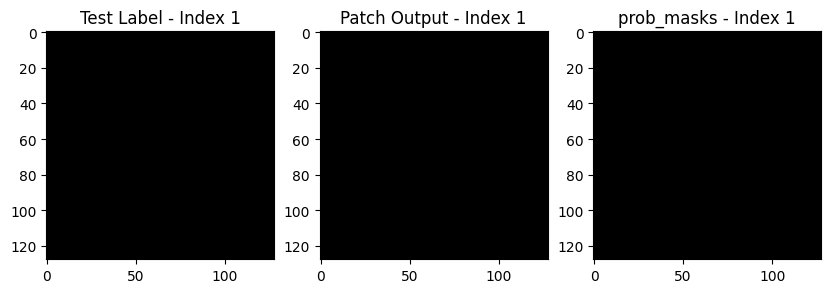

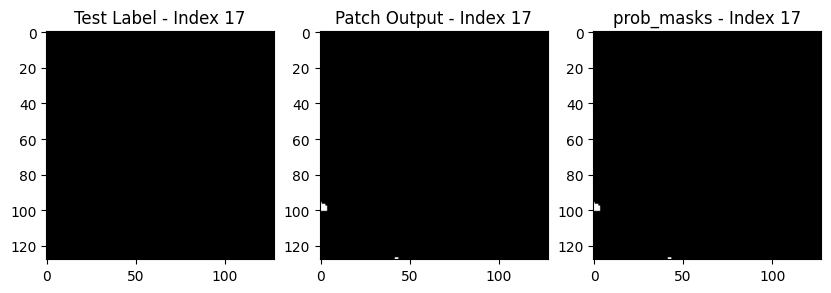

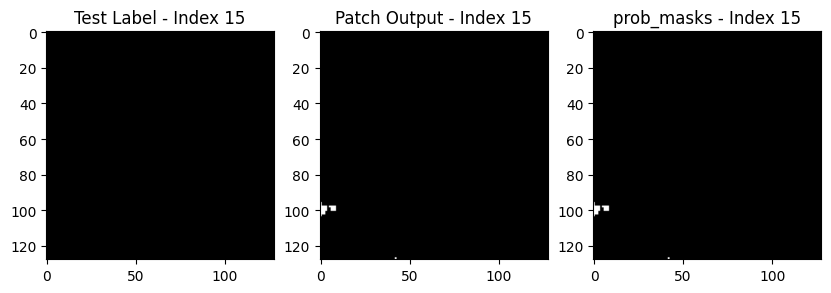

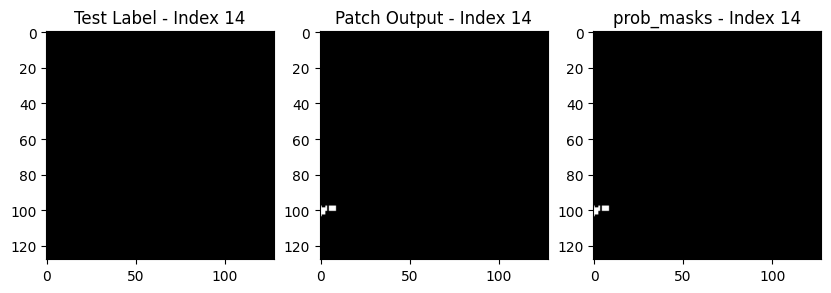

--------------------
test_loss_epoch: 0.2461
test_dice_epoch: 0.7539
current epoch: 11 current mean dice: 0.5047
best mean dice: 0.7855 at epoch: 5
----------
epoch 12/20
1/9, Train_loss: 0.2285
Train_batch_dice: 0.7715
2/9, Train_loss: 0.2337
Train_batch_dice: 0.7663
3/9, Train_loss: 0.2292
Train_batch_dice: 0.7708
4/9, Train_loss: 0.2281
Train_batch_dice: 0.7719
5/9, Train_loss: 0.2344
Train_batch_dice: 0.7656
6/9, Train_loss: 0.2299
Train_batch_dice: 0.7701
7/9, Train_loss: 0.2365
Train_batch_dice: 0.7635
8/9, Train_loss: 0.2206
Train_batch_dice: 0.7794
9/9, Train_loss: 0.2056
Train_batch_dice: 0.7944
--------------------
Total_Epoch_loss: 0.2274
Total_Epoch_dice_metric: 0.7726
1/ 4 , Test_loss: 0.2602
Test_batch_dice: 0.7398
2/ 4 , Test_loss: 0.2453
Test_batch_dice: 0.7547
3/ 4 , Test_loss: 0.2708
Test_batch_dice: 0.7292
4/ 4 , Test_loss: 0.2134
Test_batch_dice: 0.7866
5/ 4 , Test_loss: 0.2414
Test_batch_dice: 0.7586
6/ 4 , Test_loss: 0.2461
Test_batch_dice: 0.7539
7/ 4 , Test_loss

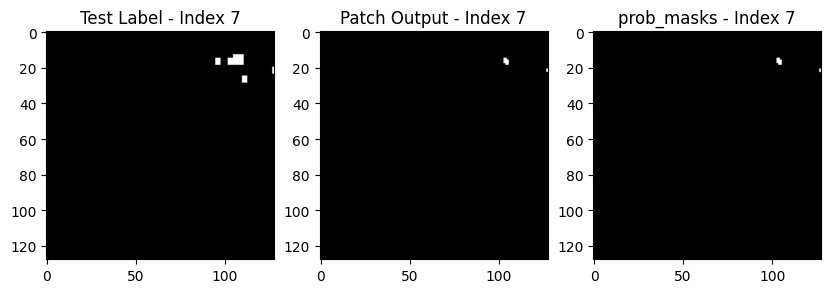

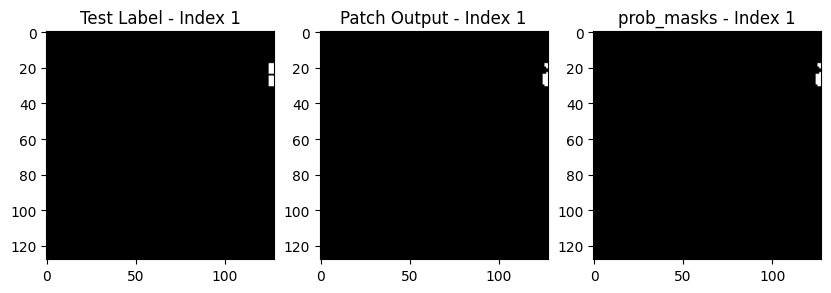

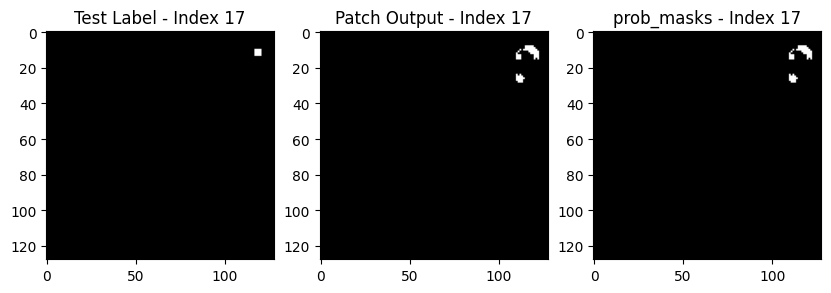

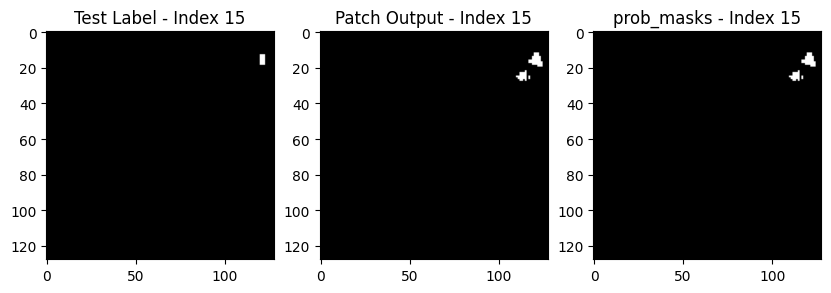

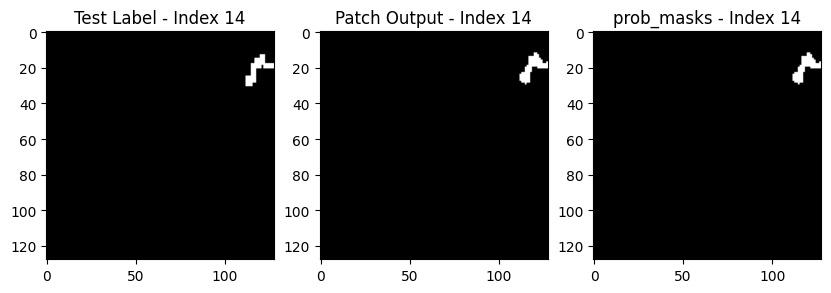

--------------------
test_loss_epoch: 0.2468
test_dice_epoch: 0.7532
current epoch: 16 current mean dice: 0.6792
best mean dice: 0.7855 at epoch: 5
----------
epoch 17/20
1/9, Train_loss: 0.2228
Train_batch_dice: 0.7772
2/9, Train_loss: 0.2165
Train_batch_dice: 0.7835
3/9, Train_loss: 0.2156
Train_batch_dice: 0.7844
4/9, Train_loss: 0.2193
Train_batch_dice: 0.7807
5/9, Train_loss: 0.2200
Train_batch_dice: 0.7800
6/9, Train_loss: 0.2145
Train_batch_dice: 0.7855
7/9, Train_loss: 0.2049
Train_batch_dice: 0.7951
8/9, Train_loss: 0.2085
Train_batch_dice: 0.7915
9/9, Train_loss: 0.2116
Train_batch_dice: 0.7884
--------------------
Total_Epoch_loss: 0.2149
Total_Epoch_dice_metric: 0.7851
1/ 4 , Test_loss: 0.2628
Test_batch_dice: 0.7372
2/ 4 , Test_loss: 0.3146
Test_batch_dice: 0.6854
3/ 4 , Test_loss: 0.2203
Test_batch_dice: 0.7797
4/ 4 , Test_loss: 0.2306
Test_batch_dice: 0.7694
5/ 4 , Test_loss: 0.2469
Test_batch_dice: 0.7531
6/ 4 , Test_loss: 0.2210
Test_batch_dice: 0.7790
7/ 4 , Test_loss

In [28]:

if __name__ == '__main__':
    train(model, data_in, loss_function, dice_ce_loss_function, optimizer, 20, model_dir)

In [29]:
def reconstruct_and_check(model, data_reconstruct, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    
            train_loader, test_loader = data_reconstruct
            #model.cpu()
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:
                    #print(test_data["vol"].shape)
                    test_step += 1
                    
                    test_batch_loss = 0
                    batch_metric_test = 0
                    l=len(test_data["vol"])
                    for i in range(len(test_data["vol"])):
                        
                        test_volume = test_data["vol"][i]
                        test_label = test_data["seg"][i]
                        test_label = test_label != 0
                        test_volume, test_label = (test_volume.to(device), test_label.to(device))
                        
                        chunk_size = 8

                        # Split the input tensor into chunks
                        test_volume = test_volume.split(chunk_size, dim=0)

                        # Initialize an empty list to store the outputs
                        test_outputs = []

                        for chunk in test_volume:
                            # Assuming your model is named `model`
                            #print(chunk.shape)
                            output_chunk = model(chunk)
                            #print(output_chunk.shape)
                            #output_chunk = torch.argmax(output_chunk, dim=1, keepdim=True) # torch.Size([64, 2, 128, 128, 32]) to torch.Size([64, 1, 128, 128, 32])
    
                            test_outputs.append(output_chunk)

                        # Concatenate the output chunks along the batch dimension
                        test_outputs = torch.cat(test_outputs, dim=0)
                        #print(test_outputs.shape)
                        
                       
                        
                        # Create an empty tensor for the combined output with the initial shape [1, 512, 512, 128]
                        combined_output = torch.zeros(2, 384,384, 128).to(device)
                        combined_label = torch.zeros(1, 384,384, 128).to(device)

#                         test_outputs.to(device)
#                         combined_output.to(device)
#                         combined_label.to(device)
                        
                        # Assuming patch_size and stride are the same as used in SequentialPatchExtractiond
                        patch_size = (128, 128, 64)
                        stride = (128, 128, 64)

                        # Initialize counters
                        counter = 0
                        for i in range(0, combined_output.shape[1], patch_size[0]):
                            for j in range(0, combined_output.shape[2], patch_size[1]):
                                for k in range(0, combined_output.shape[3], patch_size[2]):
                                    # Extract the patch from patch_outputs
                                    patch = test_outputs[counter]
                                    label = test_label[counter]

                                    # Update the combined_output tensor with the patch
                                    combined_output[:, i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] += patch.squeeze(0).to(device)
                                    combined_label[:, i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] += label.squeeze(0).to(device)

                                    # Move to the next patch
                                    counter += 1

                        # You may need to divide by the number of patches if the overlapping patches are averaged
                        # In this case, divide by (stride_x * stride_y * stride_z)
                        # combined_output /= (stride_x * stride_y * stride_z)

                        # The combined_output now has the shape [1, 512, 512, 128]
                        combined_output=combined_output.unsqueeze(0)
                        combined_label=combined_label.unsqueeze(0)
                        #print(combined_output.shape)
                        #print(combined_label.shape)

                        
                        #test_loss = loss(test_outputs, test_label)
                        test_loss = loss(combined_output, combined_label)
                        test_batch_loss += test_loss.item()
                        
                        
                        test_metric = dice_metric(combined_output, combined_label)
                        batch_metric_test += test_metric
                    
                    l=len(test_data["vol"])
                    test_epoch_loss += (test_batch_loss / l)

                    print(
                        f"{test_step}/ {l} , "
                        f"Test_loss: {test_batch_loss / l:.4f}")


                    epoch_metric_test += (batch_metric_test / l)
                    print(f'Test_batch_dice: {batch_metric_test / l:.4f}')
                
                test_epoch_loss /= test_step    
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                
                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                
                plot_result_full(combined_output,combined_label)


In [30]:
def plot_result_full(test_outputs,test_label):
    patch_outputs = torch.argmax(test_outputs, dim=1, keepdim=True) # torch.Size([64, 2, 128, 128, 32]) to torch.Size([64, 1, 128, 128, 32])
    print(patch_outputs.shape)


    ## Set a seed for reproducibility
    random.seed(42)

    # Generate a list of 10 random indices
    random_indices = random.sample(range(32), 10)
    random_indices_p = random.sample(range(64), 10)

    print(random_indices)

    i=0
    # Plot random slices
    for idx in random_indices:
        # Plot slice from patch_outputs
        plt.figure(figsize=(10, 5))

            # Plot corresponding slice from test_label
        plt.subplot(1, 3, 1)
        plt.imshow(test_label[0, 0, :, :, idx].cpu().numpy(), cmap='gray')
        plt.title(f'Test Label - Index {idx}')

        plt.subplot(1, 3, 2)
        plt.imshow(patch_outputs[0, 0, :, :, idx].cpu().numpy(), cmap='gray')
        plt.title(f'Patch Output - Index {idx}')
        #print(patch_outputs[idx, 0, :, :, patch_outputs.shape[4] // 2].cpu().numpy())



        i=i+1
        pred = patch_outputs.cpu().numpy() /255.0
        prob_masks = (pred> 0.0035).astype(int)
        #print(prob_masks)

        plt.subplot(1, 3, 3)
        plt.imshow(prob_masks[0, 0, :, :, idx], cmap='gray')
        plt.title(f'prob_masks - Index {idx}')


        plt.show()

    
                

1/ 1 , Test_loss: 0.1971
Test_batch_dice: 0.8029
2/ 1 , Test_loss: 0.2039
Test_batch_dice: 0.7961
3/ 1 , Test_loss: 0.2011
Test_batch_dice: 0.7989
4/ 1 , Test_loss: 0.1919
Test_batch_dice: 0.8081
5/ 1 , Test_loss: 0.2062
Test_batch_dice: 0.7938
6/ 1 , Test_loss: 0.2003
Test_batch_dice: 0.7997
7/ 1 , Test_loss: 0.2001
Test_batch_dice: 0.7999
8/ 1 , Test_loss: 0.2087
Test_batch_dice: 0.7913
test_loss_epoch: 0.2012
test_dice_epoch: 0.7988
torch.Size([1, 1, 384, 384, 128])
[7, 0, 23, 8, 31, 27, 4, 29, 3, 21]


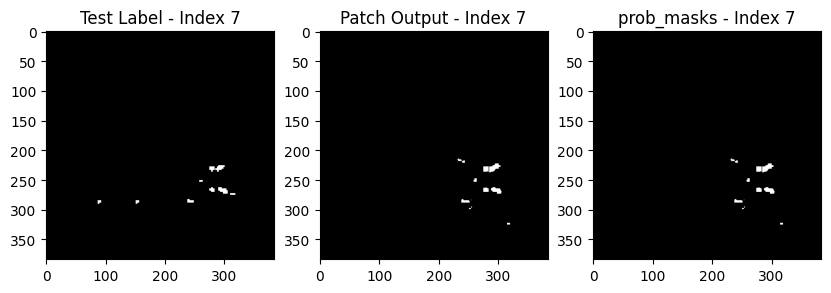

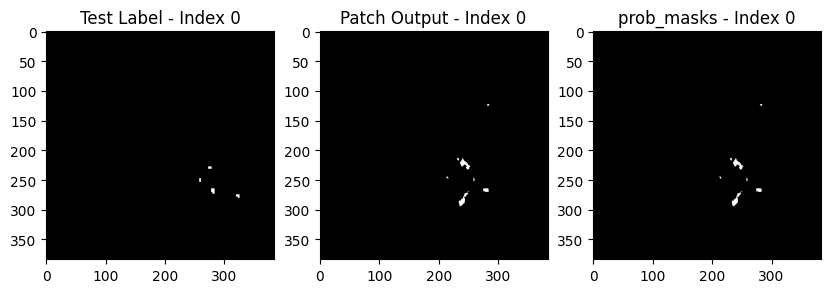

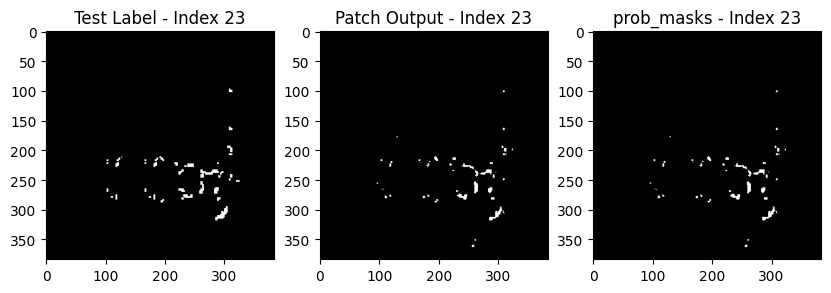

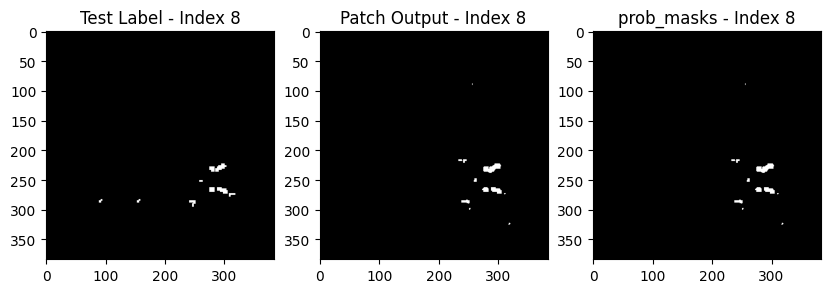

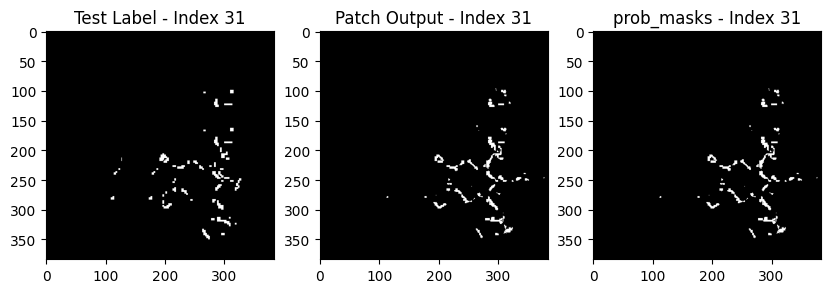

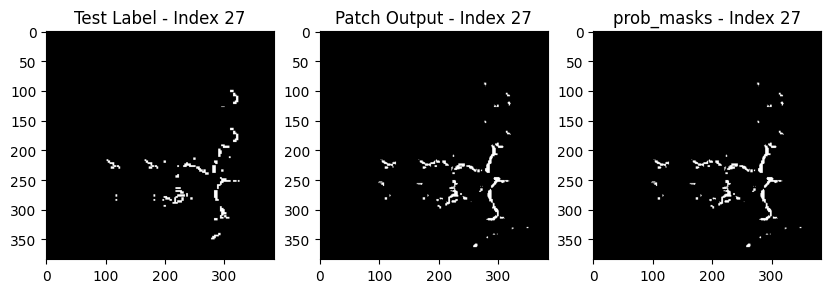

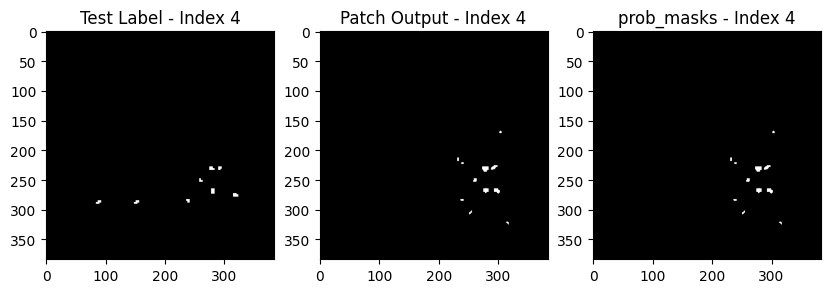

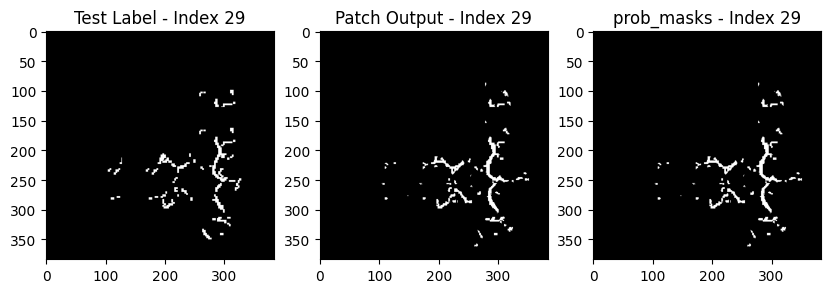

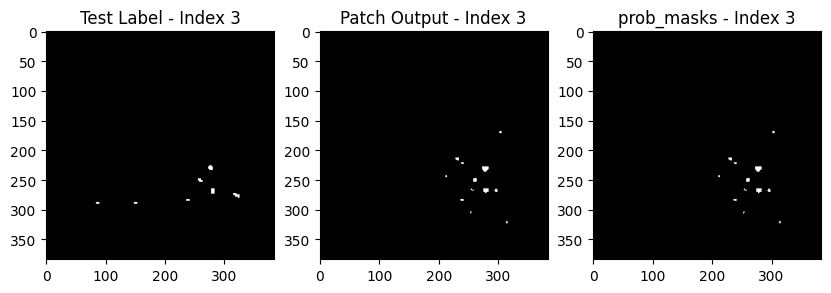

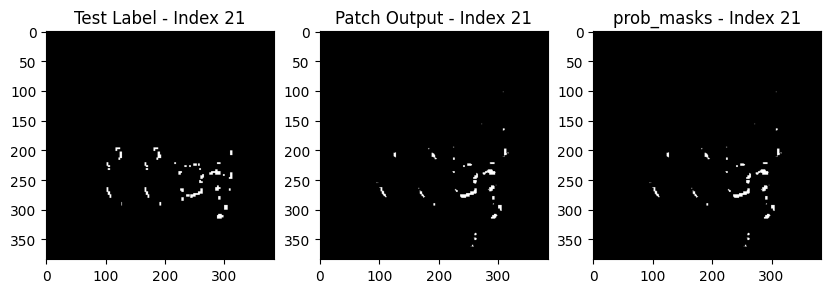

In [31]:
reconstruct_and_check(model, data_reconstruct, loss_function, optimizer, 1, model_dir)
    

In [ ]:
wt

In [ ]:

import matplotlib.pyplot as plt
import random



train_loader, test_loader = data_in
for test_data in test_loader:
                    
                    test_volume = test_data[0]["vol"]
                    test_label = test_data[0]["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    print(test_volume.shape)
                    print(test_label.shape)
                    test_outputs = model(test_volume)
                    patch_outputs = torch.argmax(test_outputs, dim=1, keepdim=True) # torch.Size([64, 2, 128, 128, 32]) to torch.Size([64, 1, 128, 128, 32])
                    break
   
 # Assuming patch_outputs is your tensor with shape [64, 1, 128, 128, 32]
# and test_label is your tensor with shape [64, 1, 128, 128, 32]

print(patch_outputs.shape)


## Set a seed for reproducibility
random.seed(42)

# Generate a list of 10 random indices
random_indices = random.sample(range(32), 10)

print(random_indices)


# Plot random slices
for idx in random_indices:
    # Plot slice from patch_outputs
    plt.figure(figsize=(10, 5))
    
        # Plot corresponding slice from test_label
    plt.subplot(1, 3, 1)
    plt.imshow(test_label[0, 0, :, :, idx].cpu().numpy(), cmap='gray')
    plt.title(f'Test Label - Index {idx}')
    
    plt.subplot(1, 3, 2)
    plt.imshow(patch_outputs[0, 0, :, :, idx].cpu().numpy(), cmap='gray')
    plt.title(f'Patch Output - Index {idx}')
    #print(patch_outputs[idx, 0, :, :, patch_outputs.shape[4] // 2].cpu().numpy())
    
    

    
    pred = patch_outputs.cpu().numpy() /255.0
    prob_masks = (pred> 0.0035).astype(int)
    #print(prob_masks)
    
    plt.subplot(1, 3, 3)
    plt.imshow(prob_masks[0, 0, :, :, idx], cmap='gray')
    plt.title(f'prob_masks - Index {idx}')
    
    
    plt.show()
    
    


In [ ]:
def reconstruct_and_check(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    
            train_loader, test_loader = data_in
            #model.cpu()
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:
                    #print(test_data["vol"].shape)
                    test_step += 1
                    
                    test_batch_loss = 0
                    batch_metric_test = 0
                    l=len(test_data["vol"])
                    for i in range(len(test_data)):
                        
                        test_volume = test_data[i]["vol"]
                        test_label = test_data[i]["seg"]
                        test_label = test_label != 0
                        test_volume, test_label = (test_volume.to(device), test_label.to(device))
                        
                        chunk_size = 8

                        # Split the input tensor into chunks
                        test_volume = test_volume.split(chunk_size, dim=0)

                        # Initialize an empty list to store the outputs
                        test_outputs = []

                        for chunk in test_volume:
                            # Assuming your model is named `model`
                            #print(chunk.shape)
                            output_chunk = model(chunk)
                            #print(output_chunk.shape)
                            #output_chunk = torch.argmax(output_chunk, dim=1, keepdim=True) # torch.Size([64, 2, 128, 128, 32]) to torch.Size([64, 1, 128, 128, 32])
    
                            test_outputs.append(output_chunk)

                        # Concatenate the output chunks along the batch dimension
                        test_outputs = torch.cat(test_outputs, dim=0)
                        #print(test_outputs.shape)
                        
                       
                        
                        # Create an empty tensor for the combined output with the initial shape [1, 512, 512, 128]
                        combined_output = torch.zeros(2, 512, 512, 128).to(device)
                        combined_label = torch.zeros(1, 512, 512, 128).to(device)

#                         test_outputs.to(device)
#                         combined_output.to(device)
#                         combined_label.to(device)
                        
                        # Assuming patch_size and stride are the same as used in SequentialPatchExtractiond
                        patch_size = (128, 128, 32)
                        stride = (128, 128, 32)

                        # Initialize counters
                        counter = 0
                        for i in range(0, combined_output.shape[1], patch_size[0]):
                            for j in range(0, combined_output.shape[2], patch_size[1]):
                                for k in range(0, combined_output.shape[3], patch_size[2]):
                                    # Extract the patch from patch_outputs
                                    patch = test_outputs[counter]
                                    label = test_label[counter]

                                    # Update the combined_output tensor with the patch
                                    combined_output[:, i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] += patch.squeeze(0).to(device)
                                    combined_label[:, i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] += label.squeeze(0).to(device)

                                    # Move to the next patch
                                    counter += 1

                        # You may need to divide by the number of patches if the overlapping patches are averaged
                        # In this case, divide by (stride_x * stride_y * stride_z)
                        # combined_output /= (stride_x * stride_y * stride_z)

                        # The combined_output now has the shape [1, 512, 512, 128]
                        combined_output=combined_output.unsqueeze(0)
                        combined_label=combined_label.unsqueeze(0)
                        #print(combined_output.shape)
                        #print(combined_label.shape)

                        
                        #test_loss = loss(test_outputs, test_label)
                        test_loss = loss(combined_output, combined_label)
                        test_batch_loss += test_loss.item()
                        
                        
                        test_metric = dice_metric(combined_output, combined_label)
                        batch_metric_test += test_metric
                    
                    l=len(test_data["vol"])
                    test_epoch_loss += (test_batch_loss / l)

                    print(
                        f"{test_step}/ {l} , "
                        f"Test_loss: {test_batch_loss / l:.4f}")


                    epoch_metric_test += (batch_metric_test / l)
                    print(f'Test_batch_dice: {batch_metric_test / l:.4f}')
                
                test_epoch_loss /= test_step    
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                
                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                
                plot_result_full(combined_output,combined_label)


In [ ]:
def plot_result_full(test_outputs,test_label):
    patch_outputs = torch.argmax(test_outputs, dim=1, keepdim=True) # torch.Size([64, 2, 128, 128, 32]) to torch.Size([64, 1, 128, 128, 32])
    print(patch_outputs.shape)


    ## Set a seed for reproducibility
    random.seed(42)

    # Generate a list of 10 random indices
    random_indices = random.sample(range(32), 5)
    random_indices_p = random.sample(range(64), 5)

    print(random_indices)

    i=0
    # Plot random slices
    for idx in random_indices:
        # Plot slice from patch_outputs
        plt.figure(figsize=(10, 5))

            # Plot corresponding slice from test_label
        plt.subplot(1, 3, 1)
        plt.imshow(test_label[0, 0, :, :, idx].cpu().numpy(), cmap='gray')
        plt.title(f'Test Label - Index {idx}')

        plt.subplot(1, 3, 2)
        plt.imshow(patch_outputs[0, 0, :, :, idx].cpu().numpy(), cmap='gray')
        plt.title(f'Patch Output - Index {idx}')
        #print(patch_outputs[idx, 0, :, :, patch_outputs.shape[4] // 2].cpu().numpy())



        i=i+1
        pred = patch_outputs.cpu().numpy() /255.0
        prob_masks = (pred> 0.0035).astype(int)
        #print(prob_masks)

        plt.subplot(1, 3, 3)
        plt.imshow(prob_masks[0, 0, :, :, idx], cmap='gray')
        plt.title(f'prob_masks - Index {idx}')


        plt.show()

    
                

In [ ]:
reconstruct_and_check(model, data_in, loss_function, optimizer, 1, model_dir)
    